Dn seems to be better. For large enough k, eventually the matrix is sparse enough that knn is not different from dn. The theoretically optimal epsilons seem to be off from the observations, except in the small k values where they are closer to the actual minimizers. Relevant figures below at the end.

In [2]:
# Solving the committor equation using the diffusion map
import numpy as np
import scipy
import csv
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20})

beta = 3

In [68]:
# The numpy-type potential function
def Vpot(xy):
    xa=-3
    ya=3
    xb=0 
    yb=4.5
    x = xy[:,0]
    y = xy[:,1]
    f=(1-x)**2+(y-0.25*x**2)**2+1
    g1=1-np.exp(-0.125*((x-xa)**2+(y-ya)**2))
    g2=1-np.exp(-0.25*(((x-xb)**2+(y-yb)**2)))
    g3=1.2-np.exp(-2*((x+0)**2+(y-2)**2))
    g4=1+np.exp(-2*(x+1.5)**2-(y-3.5)**2-(x+1)*(y-3.5))
    v = f*g1*g2*g3*g4
    return v

# define grid points
nx,ny= (100,100)
nxy = nx*ny
xmin = -4.5
xmax = 4
ymin = -3
ymax = 6
x1 = np.linspace(xmin,xmax,nx)
y1 = np.linspace(ymin,ymax,ny)
x_grid, y_grid = np.meshgrid(x1,y1)
x_vec = np.reshape(x_grid, (nxy,1))
y_vec = np.reshape(y_grid, (nxy,1))

v = np.zeros(nxy)
xy = np.concatenate((x_vec,y_vec),axis=1)
v = Vpot(xy)
v_grid = np.reshape(v,(nx,ny))    


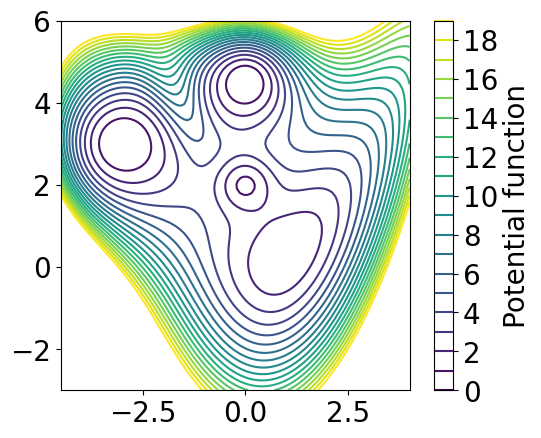

In [70]:
# plot face potential
ls = plt.contour(x_grid,y_grid,v_grid,range(0,20))
plt.colorbar(label="Potential function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)


In [ ]:
# import dataset
dd = np.load("FEM_pts_comm.npz")
xy = dd["pts"] # the FEM mesh points
q_sol = dd["comm"] # the committor values at them
# delta = data['delta']
delta = 0.05 # the parameter delta in delta-net
Ndata = np.size(xy,axis=0)
print(xy[0:10,:])

# define sets A and B
minimum_a = np.array([-3,3])
minimum_b = np.array([0,4.5])

ra = 0.5
rb = 0.5

# find indices of points in A and B and in OmegaAB
# Remove training points lying in the sets A and B
da2 = np.sum((xy - np.outer(np.ones((Ndata,)),minimum_a))**2,axis=1)
db2 = np.sum((xy - np.outer(np.ones((Ndata,)),minimum_b))**2,axis=1)
indA = np.argwhere(da2 < ra**2).ravel()
indB = np.argwhere(db2 < rb**2).ravel()
ind = np.arange(Ndata)
ind_OmegaAB = np.setdiff1d(ind, np.union1d(indA,indB))


In [584]:
# the construction of the generator matrix
def make_generator(xy, eps_par, mu):
    r2 = 9*eps_par  # radius squared of the neighborhood (removed semicolon)
    
    # construct the similarity matrix
    N = np.size(xy, axis=0)
    e0 = np.ones((N,))
    
    # Use lil_matrix for efficient construction with indexing
    K = scipy.sparse.lil_matrix((N, N), dtype=float)
    
    for j in range(N):
        d2 = np.sum((xy-np.outer(e0, xy[j,:]))**2, axis=1)
        # Use ravel() to convert to 1D array of indices
        ind = np.argwhere(d2 - r2 < 0).ravel()
        K[j, ind] = np.exp(-d2[ind]/eps_par)
    
    # Convert to CSR format for efficient arithmetic operations
    K = K.tocsr()
    
    # kernel density estimation
    c = 2*np.pi*eps_par
    rho = np.sum(K, axis=1).A.ravel()/(N*c)  # .A converts to ndarray
    
    # right-normalize K
    D = scipy.sparse.diags(np.sqrt(mu)/rho, 0)
    K = K @ D
    
    # left-normalize K
    rho = np.sum(K, axis=1).A.ravel()  # row sums of K
    D = scipy.sparse.diags(1/rho, 0)
    P = D @ K
    
    # define the generator matrix
    L = (P-scipy.sparse.eye(N, N, k=0))/eps_par
    
    return L

In [763]:
# compute the invariant measure (the target measure)
mu = np.exp(-beta*Vpot(xy))
# define the kernel bandwidth parameter: k(x,y) = exp(-||x-y||^2 / eps_par)
MAE=[]
eps_par_array=2**(np.linspace(-95,-45,30)/10)
for eps_par in eps_par_array:
  # construct the generator matrix
  L = make_generator(xy,eps_par,mu)
  q = np.zeros((Ndata,))
  q[indB] = 1.
  rhs = -np.sum(L[:,indB],axis = 1)
  L_OmegaAB = L[ind_OmegaAB, :][:, ind_OmegaAB]
  # find the committor
  q[ind_OmegaAB] = scipy.sparse.linalg.spsolve(L_OmegaAB,rhs[ind_OmegaAB])
  MAE.append(np.sum(np.abs(q_sol-q))/len(q))

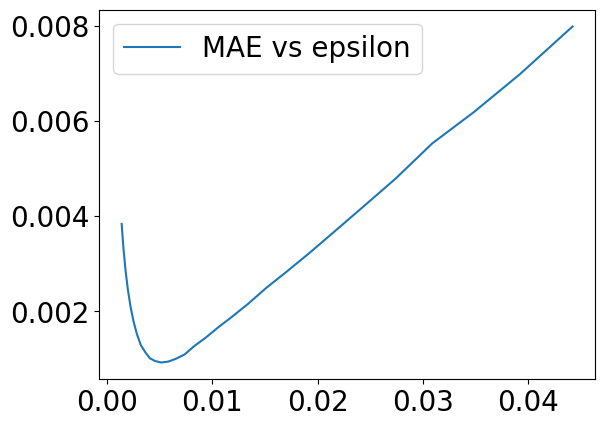

In [764]:
plt.plot(eps_par_array,MAE,label='MAE vs epsilon')
plt.legend()
plt.show()

In [733]:
val=0
argmax=0
for i in range(-95,-45):
    eps_par=2**(i/10)
    r2 = 9*eps_par  # radius squared of the neighborhood (removed semicolon)
    
    # construct the similarity matrix
    N = np.size(xy, axis=0)
    e0 = np.ones((N,))
    
    # Use lil_matrix for efficient construction with indexing
    K = np.zeros([N,N])
    d2_mat=np.zeros([N,N])
    for j in range(N):
        d2 = np.sum((xy-np.outer(e0, xy[j,:]))**2, axis=1)
        # Use ravel() to convert to 1D array of indices
        ind = np.argwhere(d2 - r2 < 0).ravel()
        d2_mat[j,:]=-d2/eps_par
        K[j, ind] = np.exp(-d2[ind]/eps_par)
    
    # Convert to CSR format for efficient arithmetic operations
    K = K
    log=d2_mat*K
    if -sum(sum(log))/sum(sum(K))>val:
        val=-sum(sum(log))/sum(sum(K))
        argmax=eps_par
print("The optimal epsilon is "+str(argmax))

The optimal epsilon is 0.01030865555291324


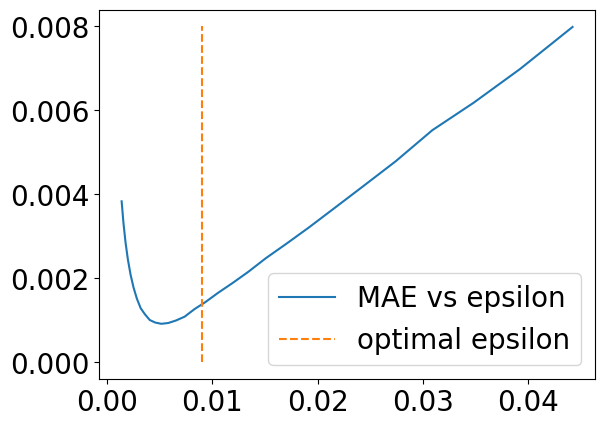

In [773]:
plt.plot(eps_par_array,MAE,label='MAE vs epsilon')
plt.plot(argmax*np.ones(10),np.linspace(0,0.008,10),'--',label='optimal epsilon')
plt.legend()
plt.show()

In [626]:
# the construction of the generator matrix
def make_generator_k(xy, eps_par, mu,k):
    r2 = 9*eps_par  # radius squared of the neighborhood (removed semicolon)
    
    # construct the similarity matrix
    N = np.size(xy, axis=0)
    e0 = np.ones((N,))
    
    # Use lil_matrix for efficient construction with indexing
    K = scipy.sparse.lil_matrix((N, N), dtype=float)
    
    for j in range(N):
        d2 = np.sum((xy-np.outer(e0, xy[j,:]))**2, axis=1)
        # Use ravel() to convert to 1D array of indices
        indexes1 = np.argwhere(d2 - r2 < 0).ravel()
        if len(indexes1)<k+1:
            ind=indexes1
        else:
            indexed_arr = [(value, index) for index, value in enumerate(d2[indexes1])]
            indexed_arr.sort(key=lambda x: x[0])
            indexes2=np.array([index for value, index in indexed_arr[:k]])
            ind=indexes1[indexes2]
        K[j, ind] = np.exp(-d2[ind]/eps_par)
    K=(K.T+K)/2
    
    # Convert to CSR format for efficient arithmetic operations
    K = K.tocsr()
    
    # kernel density estimation
    c = 2*np.pi*eps_par
    rho = np.sum(K, axis=1).A.ravel()/(N*c)  # .A converts to ndarray
    
    # right-normalize K
    D = scipy.sparse.diags(np.sqrt(mu)/rho, 0)
    K = K @ D
    
    # left-normalize K
    rho = np.sum(K, axis=1).A.ravel()  # row sums of K
    D = scipy.sparse.diags(1/rho, 0)
    P = D @ K
    
    # define the generator matrix
    L = (P-scipy.sparse.eye(N, N, k=0))/eps_par
    
    return L

In [767]:
# compute the invariant measure (the target measure)
mu = np.exp(-beta*Vpot(xy))
# define the kernel bandwidth parameter: k(x,y) = exp(-||x-y||^2 / eps_par)
MAE1=[]
MAE2=[]
MAE3=[]
eps_par_array=2**(np.linspace(-95,-45,30)/10)
for eps_par in eps_par_array:
  # construct the generator matrix
  L1 = make_generator_k(xy,eps_par,mu,32)
  rhs1 = -np.sum(L1[:,indB],axis = 1)
  L_OmegaAB1 = L1[ind_OmegaAB, :][:, ind_OmegaAB]
  q = np.zeros((Ndata,))
  q[indB] = 1.
  # find the committor
  q[ind_OmegaAB] = scipy.sparse.linalg.spsolve(L_OmegaAB1,rhs1[ind_OmegaAB])
  MAE1.append(np.sum(np.abs(q_sol-q))/len(q))

  # construct the generator matrix
  L2 = make_generator_k(xy,eps_par,mu,64)
  rhs2 = -np.sum(L2[:,indB],axis = 1)
  L_OmegaAB2 = L2[ind_OmegaAB, :][:, ind_OmegaAB]
  q = np.zeros((Ndata,))
  q[indB] = 1.
  # find the committor
  q[ind_OmegaAB] = scipy.sparse.linalg.spsolve(L_OmegaAB2,rhs2[ind_OmegaAB])
  MAE2.append(np.sum(np.abs(q_sol-q))/len(q))

  # construct the generator matrix
  L3 = make_generator_k(xy,eps_par,mu,128)
  rhs3 = -np.sum(L3[:,indB],axis = 1)
  L_OmegaAB3 = L3[ind_OmegaAB, :][:, ind_OmegaAB]
  q = np.zeros((Ndata,))
  q[indB] = 1.
  # find the committor
  q[ind_OmegaAB] = scipy.sparse.linalg.spsolve(L_OmegaAB3,rhs3[ind_OmegaAB])
  MAE3.append(np.sum(np.abs(q_sol-q))/len(q))

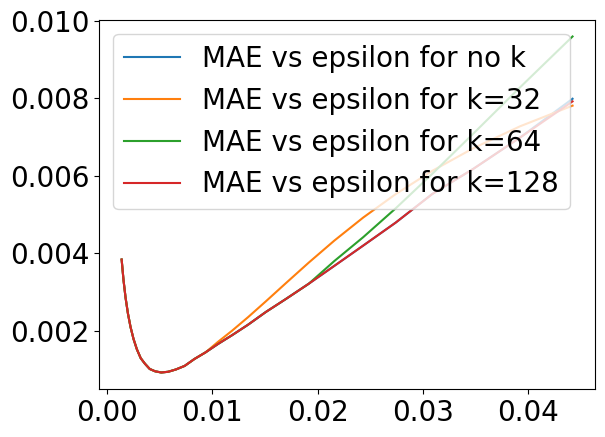

In [771]:
plt.plot(eps_par_array,MAE,label='MAE vs epsilon for no k')
plt.plot(eps_par_array,MAE1,label='MAE vs epsilon for k=32')
plt.plot(eps_par_array,MAE2,label='MAE vs epsilon for k=64')
plt.plot(eps_par_array,MAE3,label='MAE vs epsilon for k=128')

plt.legend()
plt.show()

In [757]:
val=0
argmax=0
for i in range(-95,-60):
    eps_par=2**(i/10)
    r2 = 9*eps_par  # radius squared of the neighborhood (removed semicolon)
    
    # construct the similarity matrix
    N = np.size(xy, axis=0)
    e0 = np.ones((N,))
    
    # Use lil_matrix for efficient construction with indexing
    K = scipy.sparse.lil_matrix((N, N), dtype=float)
    d2_mat=np.zeros([N,N])
    for j in range(N):
        d2 = np.sum((xy-np.outer(e0, xy[j,:]))**2, axis=1)
        # Use ravel() to convert to 1D array of indices
        indexes1 = np.argwhere(d2 - r2 < 0).ravel()
        if len(indexes1)<31:
            ind=indexes1
        else:
            indexed_arr = [(value, index) for index, value in enumerate(d2[indexes1])]
            indexed_arr.sort(key=lambda x: x[0])
            indexes2=np.array([index for value, index in indexed_arr[:32]])
            ind=indexes1[indexes2]
        d2_mat[j,:]=-d2/eps_par
        K[j, ind] = np.exp(-d2[ind]/eps_par)
    K=(K.T+K)/2
    # Convert to CSR format for efficient arithmetic operations
    K = K.toarray()
    log=d2_mat*K
    if -sum(sum(log))/sum(sum(K))>val:
        val=-sum(sum(log))/sum(sum(K))
        argmax=eps_par
print("The optimal epsilon for k=64 is "+str(argmax))

The optimal epsilon for k=64 is 0.008974205898414337


In [738]:
val=0
argmax=0
for i in range(-95,-45):
    eps_par=2**(i/10)
    r2 = 9*eps_par  # radius squared of the neighborhood (removed semicolon)
    
    # construct the similarity matrix
    N = np.size(xy, axis=0)
    e0 = np.ones((N,))
    
    # Use lil_matrix for efficient construction with indexing
    K = scipy.sparse.lil_matrix((N, N), dtype=float)
    d2_mat=np.zeros([N,N])
    for j in range(N):
        d2 = np.sum((xy-np.outer(e0, xy[j,:]))**2, axis=1)
        # Use ravel() to convert to 1D array of indices
        indexes1 = np.argwhere(d2 - r2 < 0).ravel()
        if len(indexes1)<65:
            ind=indexes1
        else:
            indexed_arr = [(value, index) for index, value in enumerate(d2[indexes1])]
            indexed_arr.sort(key=lambda x: x[0])
            indexes2=np.array([index for value, index in indexed_arr[:64]])
            ind=indexes1[indexes2]
        d2_mat[j,:]=-d2/eps_par
        K[j, ind] = np.exp(-d2[ind]/eps_par)
    K=(K.T+K)/2
    # Convert to CSR format for efficient arithmetic operations
    K = K.toarray()
    log=d2_mat*K
    if -sum(sum(log))/sum(sum(K))>val:
        val=-sum(sum(log))/sum(sum(K))
        argmax=eps_par
print("The optimal epsilon for k=64 is "+str(argmax))

The optimal epsilon for k=64 is 0.01030865555291324


In [739]:
val=0
argmax=0
for i in range(-95,-45):
    eps_par=2**(i/10)
    r2 = 9*eps_par  # radius squared of the neighborhood (removed semicolon)
    
    # construct the similarity matrix
    N = np.size(xy, axis=0)
    e0 = np.ones((N,))
    
    # Use lil_matrix for efficient construction with indexing
    K = scipy.sparse.lil_matrix((N, N), dtype=float)
    d2_mat=np.zeros([N,N])
    for j in range(N):
        d2 = np.sum((xy-np.outer(e0, xy[j,:]))**2, axis=1)
        # Use ravel() to convert to 1D array of indices
        indexes1 = np.argwhere(d2 - r2 < 0).ravel()
        if len(indexes1)<129:
            ind=indexes1
        else:
            indexed_arr = [(value, index) for index, value in enumerate(d2[indexes1])]
            indexed_arr.sort(key=lambda x: x[0])
            indexes2=np.array([index for value, index in indexed_arr[:128]])
            ind=indexes1[indexes2]
        d2_mat[j,:]=-d2/eps_par
        K[j, ind] = np.exp(-d2[ind]/eps_par)
    K=(K.T+K)/2
    # Convert to CSR format for efficient arithmetic operations
    K = K.toarray()
    log=d2_mat*K
    if -sum(sum(log))/sum(sum(K))>val:
        val=-sum(sum(log))/sum(sum(K))
        argmax=eps_par
print("The optimal epsilon for k=128 is "+str(argmax))

The optimal epsilon for k=128 is 0.01030865555291324


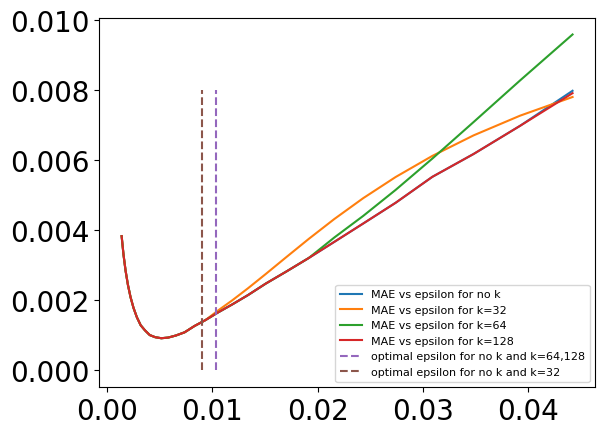

In [793]:
plt.plot(eps_par_array,MAE,label='MAE vs epsilon for no k')
plt.plot(eps_par_array,MAE1,label='MAE vs epsilon for k=32')
plt.plot(eps_par_array,MAE2,label='MAE vs epsilon for k=64')
plt.plot(eps_par_array,MAE3,label='MAE vs epsilon for k=128')
plt.plot(0.01030865555291324*np.ones(10),np.linspace(0,0.008,10),'--',label='optimal epsilon for no k and k=64,128')
plt.plot(0.008974205898414337*np.ones(10),np.linspace(0,0.008,10),'--',label='optimal epsilon for no k and k=32')

plt.legend(fontsize=8)
plt.show()